In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import utils

## Explore correlation between expression and protein level

### Protein data

Protein data extracted per (tissue, cell type). Data is filtered for approved measurements (by `Reliability`).

In [2]:
df_nt = pd.read_csv(utils.Paths.NORMAL_TISSUE_PATH, sep='\t').sort_values(["Tissue", "Cell type"])
df_nt.head(10)

,Gene,Gene name,Tissue,Cell type,Level,Reliability
0,ENSG00000000003,TSPAN6,adipose tissue,adipocytes,Not detected,Approved
80,ENSG00000000419,DPM1,adipose tissue,adipocytes,Medium,Approved
159,ENSG00000000457,SCYL3,adipose tissue,adipocytes,Low,Approved
240,ENSG00000000460,C1orf112,adipose tissue,adipocytes,Medium,Uncertain
320,ENSG00000000938,FGR,adipose tissue,adipocytes,Not detected,Enhanced
399,ENSG00000000971,CFH,adipose tissue,adipocytes,Not detected,Supported
515,ENSG00000001036,FUCA2,adipose tissue,adipocytes,Not detected,Approved
602,ENSG00000001084,GCLC,adipose tissue,adipocytes,Medium,Approved
679,ENSG00000001167,NFYA,adipose tissue,adipocytes,Not detected,Enhanced
764,ENSG00000001461,NIPAL3,adipose tissue,adipocytes,Low,Approved


In [3]:
df_g_size = df_nt.groupby(["Tissue", "Cell type", "Gene name"]).agg("size")
print(f"For the most (Tissue, Cell type, Gene name) tuples, there is 1 value: ")
df_g_size.value_counts()

For the most (Tissue, Cell type, Gene name) tuples, there is 1 value: 


1    1190725
2        313
dtype: int64

In [4]:
df_nt['Reliability'].value_counts()

Approved     459637
Enhanced     388426
Uncertain    184928
Supported    160227
Name: Reliability, dtype: int64

In [5]:
df_nt = df_nt.loc[df_nt['Reliability'] == 'Approved'].copy()
df_nt = df_nt.loc[df_nt['Level'] != 'Ascending'].copy()

level_map = {
    'Not detected': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Ascending': np.nan
}

df_nt['Level_numeric'] = df_nt['Level'].map(level_map)
df_nt['Level_numeric'] = df_nt['Level_numeric'].astype(np.int8)

In [6]:
df_prot = df_nt.groupby(["Tissue", "Cell type", "Gene name"])[['Level_numeric']].max()
df_prot.head()

Level_numeric
Tissue         Cell type  Gene name               
adipose tissue adipocytes AAAS                   0
                          AACS                   2
                          AADAC                  0
                          AAMP                   3
                          AARS2                  1

### Transcript data

pTPMs are used for transcript abundance measurement. For each (Tissue, Cell type, Gene name), values are median-aggregated over the clusters

In [7]:
df_ts = pd.read_csv(utils.Paths.RNA_TISSUES_PATH, sep = '\t').sort_values(["Tissue", "Cell type"])
df_ts.head(10)

,Gene,Gene name,Tissue,Cluster,Cell type,Read count,pTPM
11,ENSG00000000003,TSPAN6,adipose tissue,c-11,adipocytes,5809519,248.2
22,ENSG00000000003,TSPAN6,adipose tissue,c-22,adipocytes,966392,132.5
455,ENSG00000000005,TNMD,adipose tissue,c-11,adipocytes,5809519,78.7
466,ENSG00000000005,TNMD,adipose tissue,c-22,adipocytes,966392,41.4
899,ENSG00000000419,DPM1,adipose tissue,c-11,adipocytes,5809519,53.5
910,ENSG00000000419,DPM1,adipose tissue,c-22,adipocytes,966392,31.0
1343,ENSG00000000457,SCYL3,adipose tissue,c-11,adipocytes,5809519,6.4
1354,ENSG00000000457,SCYL3,adipose tissue,c-22,adipocytes,966392,4.1
1787,ENSG00000000460,C1orf112,adipose tissue,c-11,adipocytes,5809519,1.7
1798,ENSG00000000460,C1orf112,adipose tissue,c-22,adipocytes,966392,0.0


In [8]:
df_g_size = df_ts.groupby(["Tissue", "Cell type", "Gene name", "Cluster"]).agg("size")
print(f"Value counts for (Tissue, Cell type, Gene name, Cluster) similar to above, but need to average over clusters:")
df_g_size.value_counts()

Value counts for (Tissue, Cell type, Gene name, Cluster) similar to above, but need to average over clusters:


1    8912856
2       3552
dtype: int64

In [9]:
df_tx = df_ts.groupby(["Tissue", "Cell type", "Gene name"])[['pTPM']].median()
df_tx.head()

pTPM
Tissue         Cell type  Gene name         
adipose tissue adipocytes A1BG          8.45
                          A1CF          0.00
                          A2M        1126.70
                          A2ML1         0.00
                          A3GALT2       0.00

### Correlate naively protein - expression

In [47]:
df = pd.merge(df_prot, df_tx, how = "inner", left_index = True, right_index = True)
df = df.rename(columns = {
    "Level_numeric": "Protein_level",
})

df['log_pTPM'] = np.log(df['pTPM'] + 1e-3)

df.reset_index(inplace = True)

df.head()

,Tissue,Cell type,Gene name,Protein_level,pTPM,log_pTPM
0,adipose tissue,adipocytes,AAAS,0,13.90,2.631961
1,adipose tissue,adipocytes,AACS,2,7.70,2.041350
2,adipose tissue,adipocytes,AADAC,0,91.65,4.517988
3,adipose tissue,adipocytes,AAMP,3,62.00,4.127151
4,adipose tissue,adipocytes,AARS2,1,2.75,1.011964


In [48]:
def add_gene_ranks(df) -> pd.DataFrame:
    df_ = df.copy()
    gene_ranks_per_celltype = df_.set_index(['Tissue', 'Cell type']).groupby(['Tissue', 'Cell type'])['pTPM'].rank()
    df_['pTPM_rank'] = gene_ranks_per_celltype.values
    return df_

df = add_gene_ranks(df)
df.head()

,Tissue,Cell type,Gene name,Protein_level,pTPM,log_pTPM,pTPM_rank
0,adipose tissue,adipocytes,AAAS,0,13.90,2.631961,2613.0
1,adipose tissue,adipocytes,AACS,2,7.70,2.041350,1908.5
2,adipose tissue,adipocytes,AADAC,0,91.65,4.517988,4909.0
3,adipose tissue,adipocytes,AAMP,3,62.00,4.127151,4614.0
4,adipose tissue,adipocytes,AARS2,1,2.75,1.011964,1214.5


<AxesSubplot:xlabel='Protein_level', ylabel='pTPM_rank'>

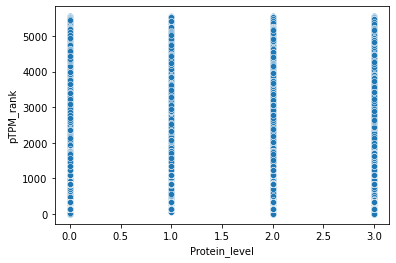

In [49]:
sns.scatterplot(data=df, x='Protein_level', y='pTPM_rank')

In [89]:
def compute_correlations(x, y, verbose = False) -> tuple:

    pearson_r = stats.pearsonr(x, y)
    kendall_tau = stats.kendalltau(x, y)
    spearman_r = stats.spearmanr(x, y)

    if verbose:
        print(f"""
            Pearson: {pearson_r}
            Kendall: {kendall_tau}
            Spearman: {spearman_r}
        """)

    df = pd.DataFrame.from_dict(
        {
            "pearson_r": pearson_r[0],
            "pearson_pval": pearson_r[1],
            # "spearman_r": spearman_r[0],
            # "spearman_pval": spearman_r[1],
            # "kendall_tau": kendall_tau[0],
            # "kendall_pval": kendall_tau[1],
            "N": x.shape[0],
            "Num_x_zero": int(sum(x == 0.)),
            "Num_x_same": int(sum(x == x.value_counts().index[0]))
        },
        orient='index'
    )

    return df.transpose()  # (pearson_r, kendall_tau, spearman_r)

compute_correlations(df['Protein_level'], df['pTPM_rank'])

,pearson_r,pearson_pval,N,Num_x_zero,Num_x_same
0,0.239095,0.0,53143.0,22787.0,22787.0


In [90]:
def compute_grouped_correlations(df: pd.DataFrame, col1: str, col2: str, grouping: list) -> pd.DataFrame:
    df_ = df.copy()
    return df_.groupby(grouping).apply(lambda df_in: compute_correlations(df_in[col1], df_in[col2]))

compute_grouped_correlations(df, grouping = ['Tissue', 'Cell type'], col1 = 'Protein_level', col2 = 'pTPM_rank')

pearson_r   pearson_pval  \
Tissue          Cell type                                                
adipose tissue  adipocytes                 0   0.145930   1.685148e-27   
breast          adipocytes                 0   0.105460   7.609568e-15   
esophagus       squamous epithelial cells  0   0.302598  1.965203e-117   
heart muscle    cardiomyocytes             0   0.207904   3.071683e-55   
liver           cholangiocytes             0   0.135423   5.935392e-24   
                hepatocytes                0   0.230361   9.480953e-68   
lung            endothelial cells          0   0.134048   7.362174e-02   
                macrophages                0   0.281917  8.290053e-102   
pancreas        exocrine glandular cells   0   0.321684  9.863007e-134   
                pancreatic endocrine cells 0   0.247246   3.843937e-74   
placenta        cytotrophoblasts           0   0.942809   5.719096e-02   
                endothelial cells          0   0.730297   2.697033e-01   
                hofbauer cells             0   0.894427   1.055728e-01   
small intestine paneth cells               0  -0.290649   2.273639e-01   
testis          peritubular cells          0  -0.025261   2.873442e-01   
                sertoli cells              0  -0.041428   8.091806e-02   

                                                   N  Num_x_zero  Num_x_same  
Tissue          Cell type                                                     
adipose tissue  adipocytes                 0  5487.0      3215.0      3215.0  
breast          adipocytes                 0  5406.0      3866.0      3866.0  
esophagus       squamous epithelial cells  0  5529.0      1462.0      2232.0  
heart muscle    cardiomyocytes             0  5549.0      1656.0      2134.0  
liver           cholangiocytes             0  5506.0      3208.0      3208.0  
                hepatocytes                0  5550.0      2080.0      2080.0  
lung            endothelial cells          0   179.0       121.0       121.0  
                macrophages                0  5544.0      1367.0      2373.0  
pancreas        exocrine glandular cells   0  5547.0      1285.0      2162.0  
                pancreatic endocrine cells 0  5263.0      1837.0      1837.0  
placenta        cytotrophoblasts           0     4.0         2.0         2.0  
                endothelial cells          0     4.0         1.0         2.0  
                hofbauer cells             0     4.0         2.0         2.0  
small intestine paneth cells               0    19.0        12.0        12.0  
testis          peritubular cells          0  1776.0      1573.0      1573.0  
                sertoli cells              0  1776.0      1100.0      1100.0

In [91]:
compute_grouped_correlations(df, grouping = ['Tissue', 'Cell type'], col1 = 'Protein_level', col2 = 'log_pTPM')

pearson_r   pearson_pval  \
Tissue          Cell type                                                
adipose tissue  adipocytes                 0   0.166703   1.737101e-35   
breast          adipocytes                 0   0.104712   1.177765e-14   
esophagus       squamous epithelial cells  0   0.307670  1.549554e-121   
heart muscle    cardiomyocytes             0   0.197964   3.774303e-50   
liver           cholangiocytes             0   0.118381   1.216924e-18   
                hepatocytes                0   0.244773   1.609701e-76   
lung            endothelial cells          0   0.183429   1.397885e-02   
                macrophages                0   0.308266  2.379453e-122   
pancreas        exocrine glandular cells   0   0.344179  4.751904e-154   
                pancreatic endocrine cells 0   0.254072   2.520843e-78   
placenta        cytotrophoblasts           0   0.997755   2.245041e-03   
                endothelial cells          0   0.915292   8.470842e-02   
                hofbauer cells             0   0.919453   8.054688e-02   
small intestine paneth cells               0  -0.301879   2.090861e-01   
testis          peritubular cells          0  -0.058323   1.396122e-02   
                sertoli cells              0  -0.049214   3.809741e-02   

                                                   N  Num_x_zero  Num_x_same  
Tissue          Cell type                                                     
adipose tissue  adipocytes                 0  5487.0      3215.0      3215.0  
breast          adipocytes                 0  5406.0      3866.0      3866.0  
esophagus       squamous epithelial cells  0  5529.0      1462.0      2232.0  
heart muscle    cardiomyocytes             0  5549.0      1656.0      2134.0  
liver           cholangiocytes             0  5506.0      3208.0      3208.0  
                hepatocytes                0  5550.0      2080.0      2080.0  
lung            endothelial cells          0   179.0       121.0       121.0  
                macrophages                0  5544.0      1367.0      2373.0  
pancreas        exocrine glandular cells   0  5547.0      1285.0      2162.0  
                pancreatic endocrine cells 0  5263.0      1837.0      1837.0  
placenta        cytotrophoblasts           0     4.0         2.0         2.0  
                endothelial cells          0     4.0         1.0         2.0  
                hofbauer cells             0     4.0         2.0         2.0  
small intestine paneth cells               0    19.0        12.0        12.0  
testis          peritubular cells          0  1776.0      1573.0      1573.0  
                sertoli cells              0  1776.0      1100.0      1100.0

In [92]:
df_genes = compute_grouped_correlations(df, grouping = ['Gene name'], col1 = 'Protein_level', col2 = 'log_pTPM')
df_genes.sort_values('pearson_pval', ascending = True).head(20)

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,,pearson_r,pearson_pval,N,Num_x_zero,Num_x_same
Gene name,,,,,,
CLEC4D,0,1.000000,0.000000e+00,11.0,10.0,10.0
ST8SIA2,0,1.000000,0.000000e+00,9.0,8.0,8.0
KCNA4,0,1.000000,4.747586e-56,9.0,8.0,8.0
UTP4,0,-0.989217,4.241917e-07,9.0,8.0,8.0
NBPF3,0,-0.973636,4.421045e-07,11.0,10.0,10.0
SLC27A6,0,0.979280,4.131957e-06,9.0,7.0,7.0
ARSK,0,-0.953089,2.001803e-05,10.0,9.0,9.0
SOCS7,0,-0.921085,5.686197e-05,11.0,9.0,9.0
SAMD10,0,0.927645,1.098109e-04,10.0,2.0,7.0


In [93]:
df_genes.sort_values(['Num_x_zero', 'pearson_pval'], ascending = True).head(20)

,,pearson_r,pearson_pval,N,Num_x_zero,Num_x_same
Gene name,,,,,,
EIF5A2,0,0.805702,0.002755,11.0,0.0,8.0
APMAP,0,0.837419,0.004848,9.0,0.0,4.0
PDZRN3,0,0.866466,0.005373,8.0,0.0,5.0
COPRS,0,-0.862064,0.005901,8.0,0.0,5.0
PIK3R4,0,-0.824885,0.006206,9.0,0.0,6.0
DDX60,0,-0.845901,0.008124,8.0,0.0,4.0
CX3CL1,0,-0.808535,0.008339,9.0,0.0,7.0
C14orf93,0,0.790559,0.011203,9.0,0.0,6.0
ZNF782,0,-0.778203,0.013515,9.0,0.0,6.0


In [94]:
df.loc[df['Gene name'] == "COPRS"]

,Tissue,Cell type,Gene name,Protein_level,pTPM,log_pTPM,pTPM_rank
6481,breast,adipocytes,COPRS,1,95.60,4.560183,4893.5
11899,esophagus,squamous epithelial cells,COPRS,2,18.90,2.939215,3721.0
17433,heart muscle,cardiomyocytes,COPRS,2,31.50,3.450019,5052.0
22970,liver,cholangiocytes,COPRS,1,80.20,4.384536,5017.5
28489,liver,hepatocytes,COPRS,1,46.80,3.845905,5069.5
34217,lung,macrophages,COPRS,2,17.65,2.870792,3179.5
39760,pancreas,exocrine glandular cells,COPRS,1,43.55,3.773933,4929.5
45247,pancreas,pancreatic endocrine cells,COPRS,1,53.60,3.981568,4610.0


## Compute correlations on LRI genes

In [14]:
df_lri = pd.read_csv("LRI_human.tsv", sep='\t', error_bad_lines=False)
df_lri.head(3)

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 3385: expected 8 fields, saw 10\nSkipping line 3392: expected 8 fields, saw 10\nSkipping line 3397: expected 8 fields, saw 10\n'


,LRI,LIGAND_1,LIGAND_2,RECEPTOR_1,RECEPTOR_2,RECEPTOR_3,DATABASE,SOURCE
0,CRISP3:A1BG,CRISP3,NaN,A1BG,NaN,NaN,CellTalkDB,PMID:15461460
1,A2M:LRP1,A2M,NaN,LRP1,NaN,NaN,CellTalkDB;connectomeDB2020;NicheNet;SingleCel...,FANTOM5;HPMR;HPRD;PMID:10652313;PMID:12194978;...
2,AANAT:MTNR1A,AANAT,NaN,MTNR1A,NaN,NaN,CellTalkDB;connectomeDB2020;NicheNet;SingleCel...,FANTOM5;HPMR;PMID:12943195


In [15]:
ligands = (
    set(df_lri['LIGAND_1'])
    .union(set(df_lri['LIGAND_2']))
)
receptors = (
    set(df_lri['RECEPTOR_1'])
    .union(set(df_lri['RECEPTOR_2']))
    .union(set(df_lri['RECEPTOR_3']))
)

In [16]:
print("Correlations on ligands")

df_l = df.loc[df['Gene name'].isin(ligands)]
print(f"Shape of HPA from LRI ligands: {df_l.shape}")

df_l = add_gene_ranks(df_l)

compute_correlations(df_l['Protein_level'], df_l['pTPM_rank'], verbose = True);

Correlations on ligands
Shape of HPA from LRI ligands: (1808, 7)

        Pearson: (0.19122477079776634, 2.380836199053689e-16)
        Kendall: KendalltauResult(correlation=0.1615292760091207, pvalue=1.8312026185142895e-18)
        Spearman: SpearmanrResult(correlation=0.20535507141988285, pvalue=1.1452215549443404e-18)
    


In [17]:
print("Correlations on receptors")

df_r = df.loc[df['Gene name'].isin(receptors)]
print(f"Shape of HPA from LRI ligands: {df_r.shape}")

df_r = add_gene_ranks(df_r)

compute_correlations(df_r['Protein_level'], df_r['pTPM_rank'], verbose = True);

Correlations on receptors
Shape of HPA from LRI ligands: (2264, 7)

        Pearson: (0.28130797607408065, 1.902552180493847e-42)
        Kendall: KendalltauResult(correlation=0.21902757385359717, pvalue=2.143637900785664e-41)
        Spearman: SpearmanrResult(correlation=0.28322209633179696, pvalue=5.008499255512636e-43)
    


### Compute tissue and celltype-level correlations

In [32]:
compute_grouped_correlations(df_l, grouping = ['Tissue', 'Cell type'], col1 = 'Protein_level', col2 = 'pTPM_rank')

pearson_r  pearson_pval  \
Tissue         Cell type                                               
adipose tissue adipocytes                 0   0.209722      0.003775   
breast         adipocytes                 0   0.194903      0.007199   
esophagus      squamous epithelial cells  0   0.231219      0.001290   
heart muscle   cardiomyocytes             0   0.181448      0.012231   
liver          cholangiocytes             0   0.109504      0.133624   
               hepatocytes                0   0.159831      0.027612   
lung           macrophages                0   0.225535      0.001707   
pancreas       exocrine glandular cells   0   0.176688      0.014481   
               pancreatic endocrine cells 0   0.268310      0.000231   
testis         peritubular cells          0   0.102819      0.468244   
               sertoli cells              0  -0.265236      0.057389   

                                             spearman_r  spearman_pval  \
Tissue         Cell type                                                 
adipose tissue adipocytes                 0    0.221387       0.002203   
breast         adipocytes                 0    0.213157       0.003231   
esophagus      squamous epithelial cells  0    0.245021       0.000635   
heart muscle   cardiomyocytes             0    0.194885       0.007050   
liver          cholangiocytes             0    0.129843       0.074952   
               hepatocytes                0    0.143317       0.048535   
lung           macrophages                0    0.233807       0.001133   
pancreas       exocrine glandular cells   0    0.186424       0.009818   
               pancreatic endocrine cells 0    0.293282       0.000053   
testis         peritubular cells          0    0.092267       0.515329   
               sertoli cells              0   -0.268548       0.054232   

                                             kendall_tau  kendall_pval  
Tissue         Cell type                                                
adipose tissue adipocytes                 0     0.176057      0.002418  
breast         adipocytes                 0     0.172127      0.003507  
esophagus      squamous epithelial cells  0     0.196239      0.000675  
heart muscle   cardiomyocytes             0     0.153525      0.007389  
liver          cholangiocytes             0     0.109643      0.074786  
               hepatocytes                0     0.120515      0.043653  
lung           macrophages                0     0.185677      0.001178  
pancreas       exocrine glandular cells   0     0.151871      0.008702  
               pancreatic endocrine cells 0     0.233177      0.000072  
testis         peritubular cells          0     0.074803      0.522789  
               sertoli cells              0    -0.234780      0.053586

In [33]:
compute_grouped_correlations(df_r, grouping = ['Tissue', 'Cell type'], col1 = 'Protein_level', col2 = 'pTPM_rank')

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


pearson_r  pearson_pval  \
Tissue         Cell type                                               
adipose tissue adipocytes                 0   0.153338  1.744613e-02   
breast         adipocytes                 0   0.114489  7.921555e-02   
esophagus      squamous epithelial cells  0   0.399040  1.378803e-10   
heart muscle   cardiomyocytes             0   0.307206  1.220914e-06   
liver          cholangiocytes             0   0.223581  5.247593e-04   
               hepatocytes                0   0.263252  3.766166e-05   
lung           endothelial cells          0        NaN           NaN   
               macrophages                0   0.230198  3.231459e-04   
pancreas       exocrine glandular cells   0   0.366088  5.035182e-09   
               pancreatic endocrine cells 0   0.374875  5.099814e-09   
testis         peritubular cells          0   0.013429  9.181869e-01   
               sertoli cells              0   0.037184  7.760201e-01   

                                             spearman_r  spearman_pval  \
Tissue         Cell type                                                 
adipose tissue adipocytes                 0    0.167175   9.469305e-03   
breast         adipocytes                 0    0.110243   9.107592e-02   
esophagus      squamous epithelial cells  0    0.391375   3.300688e-10   
heart muscle   cardiomyocytes             0    0.311065   8.816838e-07   
liver          cholangiocytes             0    0.259248   5.362338e-05   
               hepatocytes                0    0.276058   1.492362e-05   
lung           endothelial cells          0         NaN            NaN   
               macrophages                0    0.230001   3.270943e-04   
pancreas       exocrine glandular cells   0    0.376559   1.676012e-09   
               pancreatic endocrine cells 0    0.380926   2.748741e-09   
testis         peritubular cells          0   -0.020315   8.765040e-01   
               sertoli cells              0    0.057057   6.622822e-01   

                                             kendall_tau  kendall_pval  
Tissue         Cell type                                                
adipose tissue adipocytes                 0     0.132663  1.028587e-02  
breast         adipocytes                 0     0.089139  9.120350e-02  
esophagus      squamous epithelial cells  0     0.317802  4.708436e-10  
heart muscle   cardiomyocytes             0     0.234577  2.891425e-06  
liver          cholangiocytes             0     0.218090  5.643284e-05  
               hepatocytes                0     0.225056  2.037581e-05  
lung           endothelial cells          0          NaN           NaN  
               macrophages                0     0.177629  3.940997e-04  
pancreas       exocrine glandular cells   0     0.291419  9.668648e-09  
               pancreatic endocrine cells 0     0.303941  7.501886e-09  
testis         peritubular cells          0    -0.019638  8.627882e-01  
               sertoli cells              0     0.053417  6.491813e-01